# Map, Reduce, and Multiprocessing

Multiprocessing capabilities can be an effective tool for speeding up a time-consuming workflow by making it possible to execute portions of the workflow in parallel across multiple CPU cores. However, for more complex workflows, data and control flow dependencies that can lead to race conditions can make implementation, debugging, and maintenance more challenging.

One approach to consider when planning a new workflow is whether the workflow is amenable to a more functional implementation that leverages *map* and *reduce* operations (*i.e.,* whether it is compatible with the [MapReduce](https://en.wikipedia.org/wiki/MapReduce) paradigm). In practice, many common workflows that can be parallelized are also possible to implement in this paradigm. If this fits your workflow, you can take advantage of this to make your use multiprocessing solution simpler, more elegant, and easier to maintain.

## Map and Reduce

Because Python supports the functional programming paradigm and has built-in `map` and `reduce` functions, it is straightforward to prototype a solution to a problem using these building blocks.

A popular use case used in introductory materials on frameworks that support the MapReduce paradigm is that of empirically estimating the value of $\pi$. The formula for the area $A$ of a circle having radius $r$ is $A = \pi r^2$, so the radius and area of a circle can be used to compute $\pi = A/r^2$. Letting $r = \frac{1}{2}$ yields

$$\pi = \frac{A}{\Big(\frac{1}{2}\Big)^2} = 4A.$$

So it is only necessary to multiply by $4$ the area of a circle having a radius of $\frac{1}{2}$.

A circle with a radius of $\frac{1}{2}$ has a diameter of $1$ and so it fits perfectly inside a square having sides of length $1$ and thus an area of $1 \cdot 1 = 1$. Thus, it is possible to estimate $A$ by generating random points inside the square of area $1$ and counting how many of the points are actually inside the circle of radius $\frac{1}{2}$. Each point has a probability of $\frac{A}{1}$ of being inside the circle. After generating $n$ random points, if $k$ of them are in the circle then the equation below should hold:

$$\frac{A}{1} = \frac{k}{n}.$$

This can then be used to compute the approximation $\pi \approx 4 \cdot \frac{k}{n}$. Below, a plot is generated that illustrates how this estimate can be computed.

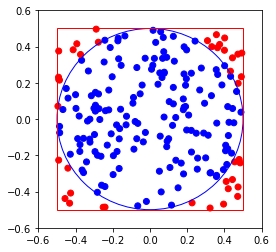

3.18

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as fig
import matplotlib.patches as pch
import numpy as np

# Draw the Cartesian plane between (-0.6, -0,6) and (0.6, 0.6).
fig = plt.figure(figsize=fig.figaspect(1))
axes = fig.add_subplot(1, 1, 1)
axes.set_xlim(-0.6, 0.6)
axes.set_ylim(-0.6, 0.6)

# Center at origin a circle of diameter 1 and a square of area 1.
axes.add_patch(plt.Circle((0, 0), radius=0.5, edgecolor='b', facecolor='None'))
axes.add_patch(pch.Rectangle((-0.5, -0.5), 1, 1, edgecolor='r', facecolor='None'))

# Add random points and color them blue if they are in the circle.
n = 200
(x, y) = (-0.5 + np.random.rand(n), -0.5 + np.random.rand(n))
colors = ['b' if (x[i]**2 + y[i]**2 <= 0.5**2) else 'r' for i in range(n)]
plt.scatter(x, y, c=colors)

# Show the plot and the fraction of points inside the circle.
plt.show()
4 * colors.count('b') / len(colors)

To implement the same workflow using map and reduce operations, it is necessary to split the problem into two parts: (1) a step in which there is no dependency between the entries (*i.e.*, points) in the data, and (2) a step during which these entries need to be combined into a final result.

One approach that can make a MapReduce-like workflow concise to implement is to ensure that the *representation* of a data entry and a partially aggregated set of entries is always the same. This makes it possible to have just a single function that can always take two partial results and combine in into a new, larger partial result. In this example, we can choose a representation that reflects the final goal we want to compute: a count of points that are *in* the circle and a count of all the points in the square that have been generated so far.

In [1]:
{
    "circle": 314, 
    "square": 400
}

{'circle': 314, 'square': 400}

The initial data entries are now just a special case of the above: a point inside the circle is represented as `{"circle":1, "square":1}` and a point outside the circle is represented as `{"circle":0, "square":1}`. You can now implement the function `trial` below that corresponds to the map step of the MapReduce-like workflow.

In [1]:
def trial(instance):
    from random import random
    (x, y) = (-0.5 + random(), -0.5 + random())
    return {
        "circle": 1 if (x**2 + y**2 <= 0.5**2) else 0, 
        "square": 1
      }

The function `combine` for the second step is now even simpler to implement. All you need is a function that combines two aggregated estimates into a new aggregated estimate.

In [1]:
def combine(estimate_a, estimate_b):
    return {
        "circle": estimate_a["circle"] + estimate_b["circle"], 
        "square": estimate_a["square"] + estimate_b["square"]
    }

Using the `trial` and `combine` functions to implement a MapReduce-like workflow is then straightforward.

In [1]:
from functools import reduce
estimate = reduce(combine, map(trial, range(1000)))
print(estimate)
print(4 * (estimate["circle"] / estimate["square"]))

{'circle': 783, 'square': 1000}
3.132


## Partial Application of Functions

A brief digression to review higher-order functions (something covered in a [previous article on decorators](https://python.supply/higher-order-functions-and-decorators)) will be useful for our subsequent examples. Given a function that takes more than one argument, it is possible to turn that into a function that takes only the first argument and returns a new function that takes the rest of the arguments as inputs. As an example, consider the following addition function.

In [1]:
def add(x, y):
    return x + y

The following higher-order function can be used to transform it into a function that returns a function.

In [1]:
def partial_(f, x):
    def g(y):
        return f(x, y)
    return g

add_ = partial_(add, 2)
add_(3)

5

Python has a function [`partial`](https://docs.python.org/3/library/functools.html#functools.partial) in the built-in [functools](https://docs.python.org/3/library/functools.html#functools.partial) library that does exactly what `partial_` does in the above example.

In [1]:
from functools import partial
add_ = partial(add, 2)
add_(3)

5

This is actually a special case of [currying](https://en.wikipedia.org/wiki/Currying), a topic that is usually covered in materials on the functional programming paradigm and associated techniques.

## Multiprocessing

Python's built-in [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) library allows programmers to run multiple processes in parallel if the operating system and hardware support it.

Throughout the rest of this article, an auxiliary function is used that makes it easier to run the multiprocessing library within Jupyter Notebook. This function is a [decorator](https://python.supply/higher-order-functions-and-decorators) that stores the decorated function definition in a temporary module file so that the the multiprocessing library can load it.

In [1]:
def module(function):
    import os
    import importlib
    import uuid
    import inspect

    directory = '/tmp/' + __name__ + '/'
    module_name = 'tmp.' + __name__ + '.' + function.__name__
    
    if not os.path.exists('.' + directory):
        os.makedirs('.' + directory)

    filepath = '.' + directory + '/' + function.__name__ + ".py"
    with open(filepath, "w") as file:
        definition = inspect.getsource(function)
        lines = definition.split("\n")
        if lines[0] == "@module":
            definition = "\n".join(lines[1:])
        file.write(definition)

    module = importlib.import_module(module_name, package=function.__name__)
    return getattr(module, function.__name__)

One of the simplest ways to use the multiprocessing library is to create a pool of processes and have all the processes in that pool execute the same function.

In [1]:
import multiprocessing as mp

@module
def double(x):
    return x + x

with mp.Pool(processes = mp.cpu_count()) as pool:
    ys = pool.map(double, [1, 2, 3, 4])
    print(ys)

[2, 4, 6, 8]


As you can see, the API is already fairly close to a MapReduce-like workflow. However, the workflow for approximating $\pi$ (which is representative of other MapReduce-like workflows) requires that a single aggregated result value is computed at the end.

One way to proceed is to split the point generation portion of the workflow across multiple processes, with each process computing its own estimate iteratively for its subset of the total number of trials. Once all the processes compute their individual estimates, the *reduce* portion of the workflow is split into two parts:

* each process applies `reduce` to compute a single estimate for that process, and
* a global `reduce` operation is applied across all the estimates returned by all the processes.

An implementation that uses this approach is presented below.

In [1]:
@module
def trial(instance):
    from random import random
    (x, y) = (-0.5 + random(), -0.5 + random())
    return {
        "circle": 1 if (x**2 + y**2 <= 0.5**2) else 0, 
        "square": 1
      }

@module
def combine(estimate_a, estimate_b):
    return {
        "circle": estimate_a["circle"] + estimate_b["circle"], 
        "square": estimate_a["square"] + estimate_b["square"]
    }

def map_mp(pool, es):
    from functools import partial
    from parts import parts
    return pool.map(partial(map, trial), parts(es, pool._processes))

def reduce_mp(pool, es_per_process):
    from functools import partial, reduce    
    return reduce(combine, pool.map(partial(reduce, combine), es_per_process))

In [1]:
with mp.Pool(processes = mp.cpu_count()) as pool:
    es = map_mp(pool, range(10000))
    r = reduce_mp(pool, es)
    print(4*(r["circle"] / r["square"]))

3.1448


The [mr4mp](https://pypi.org/project/mr4mp/) library provides a thin wrapper API around the multiprocessing library to enable even more concise implementations of MapReduce-like workflows. Assuming the `trial` and `combine` functions have already been defined, the entire workflow can be implemented using just a few lines of code.

In [1]:
import mr4mp

result = mr4mp.pool().mapreduce(trial, combine, range(1000))
4 * (result["circle"] / result["square"])

3.132